In [56]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class TableGAN:
    def __init__(self, input_dim, z_dim=100):
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.generator = None
        self.discriminator = None
        self._scaler = MinMaxScaler(feature_range=(-1, 1))

    def _build_generator(self):
        noise_input = layers.Input(shape=(self.z_dim,))
        x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(noise_input)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        output = layers.Dense(self.input_dim, activation='tanh')(x)
        
        self.generator = tf.keras.Model(noise_input, output)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    def _build_discriminator(self):
        input_data = layers.Input(shape=(self.input_dim,))
        x = layers.Dense(512, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_data)
        x = layers.Dense(256, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        output = layers.Dense(1)(x)
        
        self.discriminator = tf.keras.Model(input_data, output)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

    def _wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)

    def _gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
        interpolated = real_samples + alpha * (fake_samples - real_samples)
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal([batch_size, self.z_dim])

        for _ in range(5):  # Multiple discriminator updates
            with tf.GradientTape() as d_tape:
                fake_data = self.generator(noise, training=True)
                real_output = self.discriminator(real_data, training=True)
                fake_output = self.discriminator(fake_data, training=True)

                d_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
                gp = self._gradient_penalty(real_data, fake_data)
                d_loss += 10 * gp

            d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            d_gradients, _ = tf.clip_by_global_norm(d_gradients, 1.0)
            self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            fake_data = self.generator(noise, training=True)
            fake_output = self.discriminator(fake_data, training=True)
            g_loss = -tf.reduce_mean(fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        g_gradients, _ = tf.clip_by_global_norm(g_gradients, 1.0)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return d_loss, g_loss

    def fit(self, x, batch_size=64, epochs=100, verbose=1):
        x = self.preprocess_data(x)
        x = self._scaler.fit_transform(x).astype(np.float32)
        
        self._build_generator()
        self._build_discriminator()

        dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch)
                d_losses.append(d_loss)
                g_losses.append(g_loss)

            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}: [D loss: {np.mean(d_losses):.4f}] [G loss: {np.mean(g_losses):.4f}]")

        return self

    def sample(self, n_samples):
        noise = tf.random.normal([n_samples, self.z_dim])
        synthetic_data = self.generator(noise, training=False)
        return self._inverse_transform(synthetic_data.numpy())

    def _inverse_transform(self, data):
        return self._scaler.inverse_transform(data)

    def load_dataset(self, dataset_name):
        data_path = f'data/{dataset_name}/train_{dataset_name}_cleaned.csv'
        return pd.read_csv(data_path)
    
    def preprocess_data(self, X):
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        X = X.dropna()
        return X.reset_index(drop=True)

In [57]:
# Load and preprocess the data
gan = TableGAN(input_dim=14)  # Adjust input_dim based on your data
X = gan.load_dataset('Adult')
X = gan.preprocess_data(X)

# Train the TableGAN model
gan.fit(X, epochs=100, batch_size=64)

# Generate synthetic samples
n_samples = 1000
synthetic_data = gan.sample(n_samples)

Epoch 0/100: [D loss: -1.4704] [G loss: 0.6963]
Epoch 10/100: [D loss: -1.9150] [G loss: 0.9552]
Epoch 20/100: [D loss: -0.7247] [G loss: -1.1513]
Epoch 30/100: [D loss: -0.4703] [G loss: -1.1620]
Epoch 40/100: [D loss: -0.4517] [G loss: -1.0108]
Epoch 50/100: [D loss: -0.4100] [G loss: -0.8638]
Epoch 60/100: [D loss: -0.3789] [G loss: -0.7182]
Epoch 70/100: [D loss: -0.3644] [G loss: -0.5785]
Epoch 80/100: [D loss: -0.3659] [G loss: -0.4085]
Epoch 90/100: [D loss: -0.3522] [G loss: -0.2691]


In [58]:
def post_process_synthetic_data(synthetic_data, original_data):
    # Create a DataFrame with the same column names as the original data
    df_synthetic = pd.DataFrame(synthetic_data, columns=original_data.columns)
    
    for column in df_synthetic.columns:
        # Check if the original column contains only integers
        if original_data[column].dtype in ['int64', 'int32']:
            df_synthetic[column] = df_synthetic[column].round().astype(int)
        else:
            # For float columns, round to the same number of decimal places as in the original data
            decimals = original_data[column].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0).max()
            df_synthetic[column] = df_synthetic[column].round(decimals)
    
    return df_synthetic

In [59]:
# Post-process the synthetic data
processed_synthetic_data = post_process_synthetic_data(synthetic_data, X)

print(processed_synthetic_data.head())

   age  workclass  fnlwgt  education  education-num  marital-status  \
0   37          0   85661          8              8               3   
1   53          0  127235          2             10               1   
2   65          0  148151          6              7               1   
3   69          1   53115          7              9               1   
4   33          2  501837          9             10               1   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           0             1     2    1          4270            13   
1           6             4     1    2            55             0   
2           3             2     1    2           203             9   
3           9             4     1    2           486             3   
4           2             5     1    2         71311            44   

   hours-per-week  native-country  
0              13               0  
1              42               0  
2              32               0  
3       

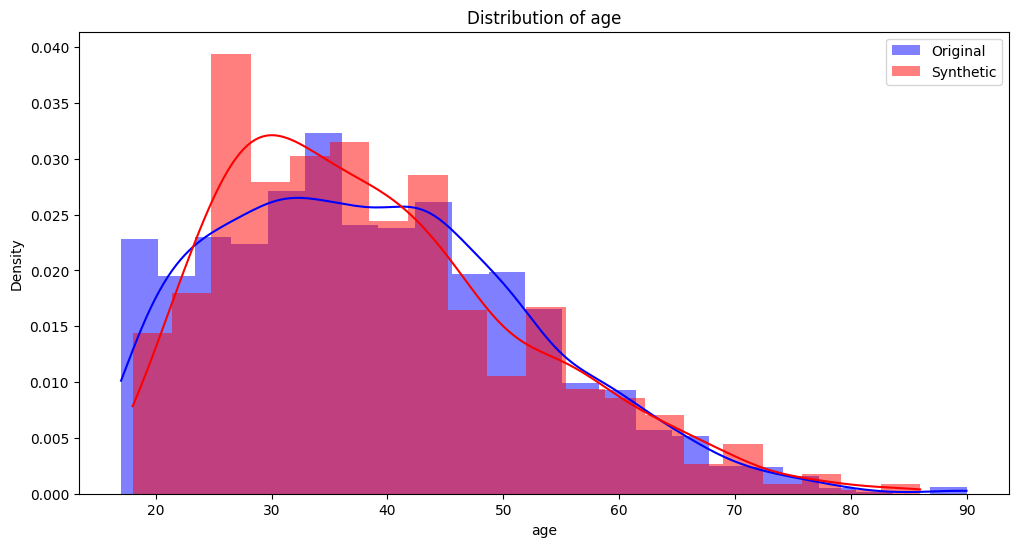

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(original, synthetic, feature_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(original[feature_name], color="blue", kde=True, stat="density", linewidth=0, label="Original")
    sns.histplot(synthetic[feature_name], color="red", kde=True, stat="density", linewidth=0, label="Synthetic")
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

# Example usage for a feature
compare_distributions(X, processed_synthetic_data, 'age')

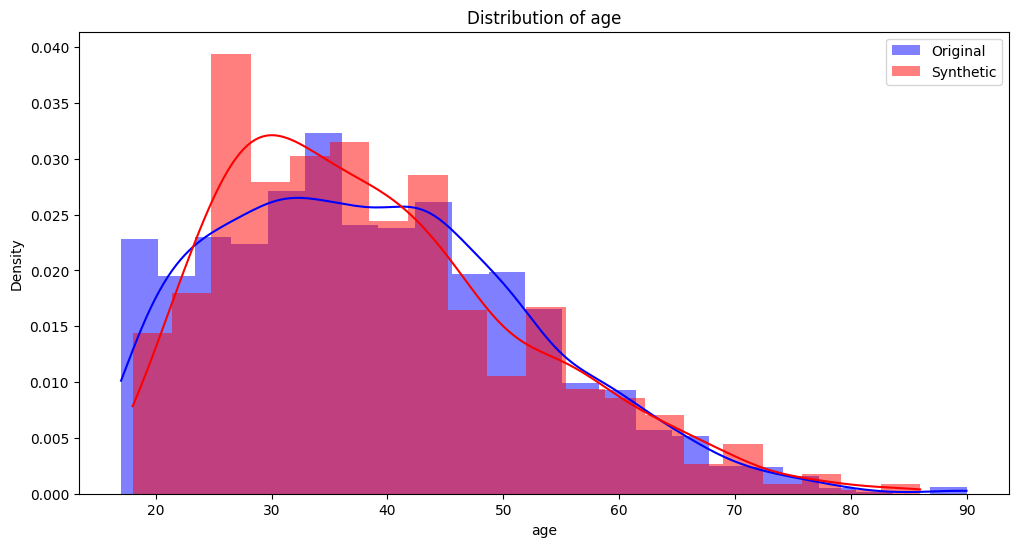

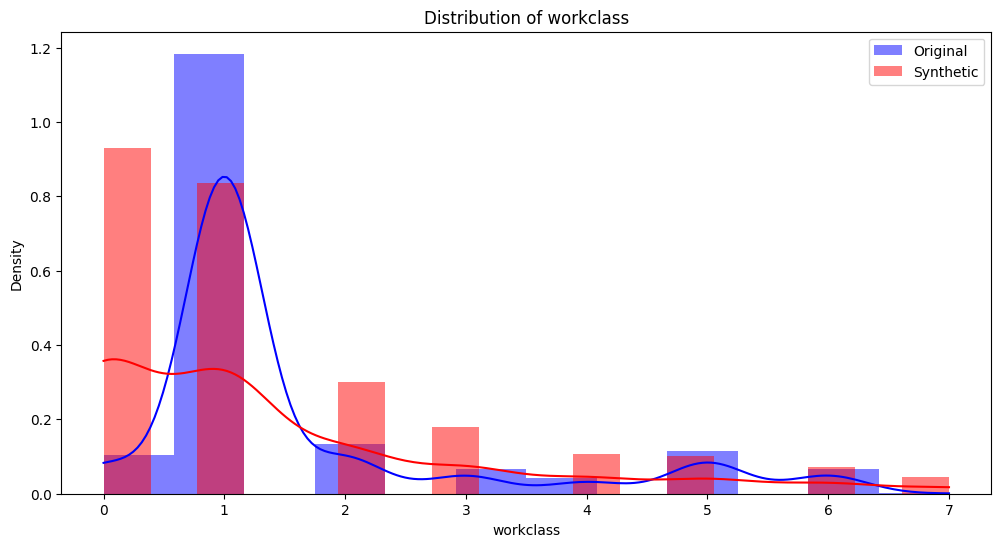

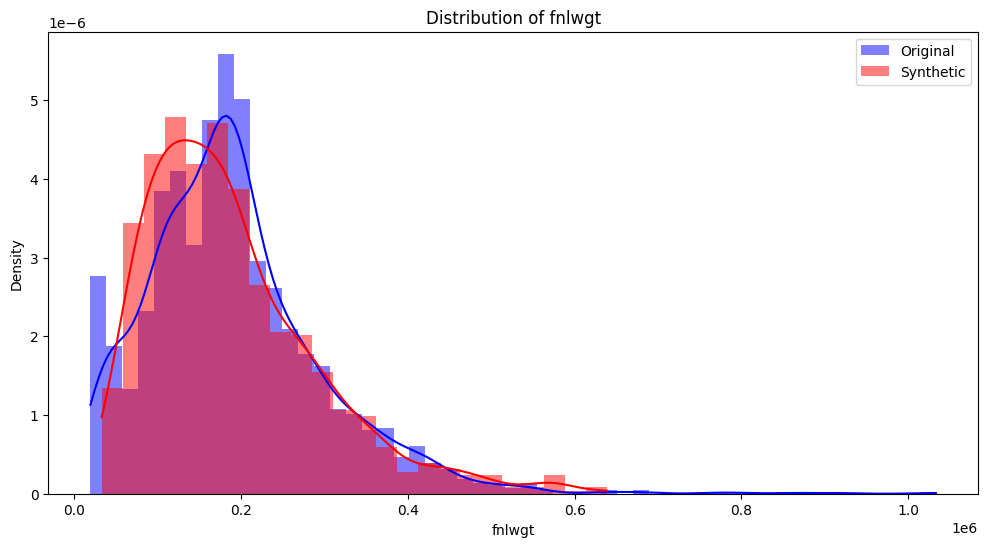

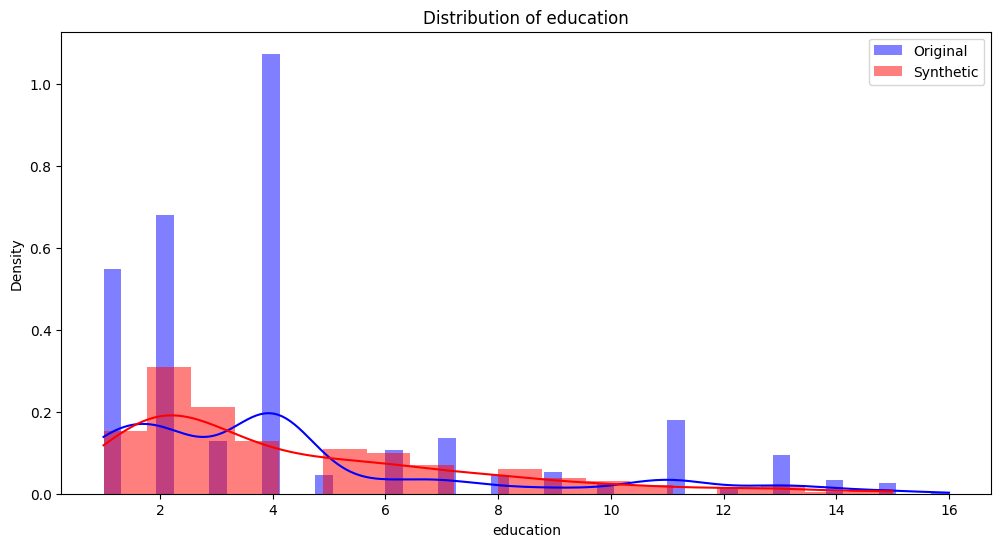

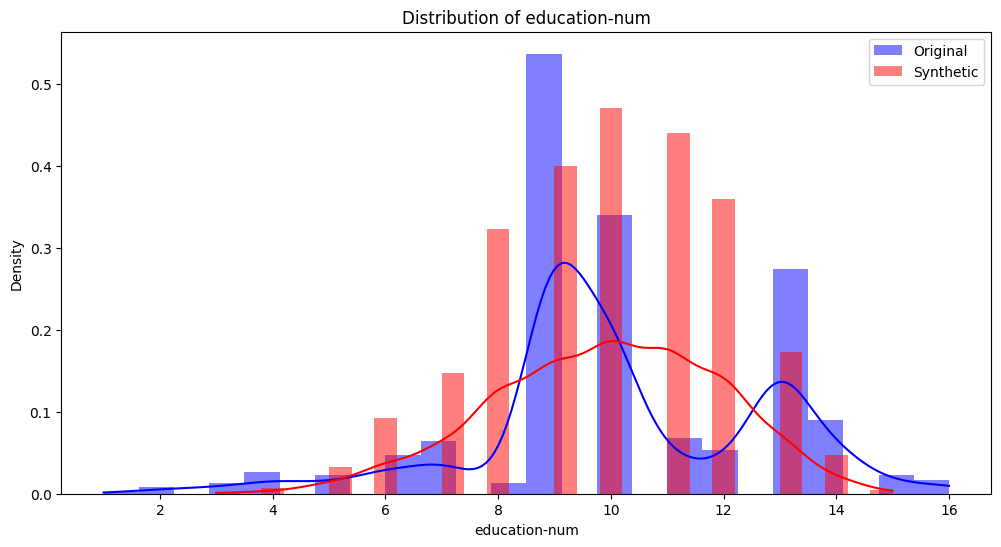

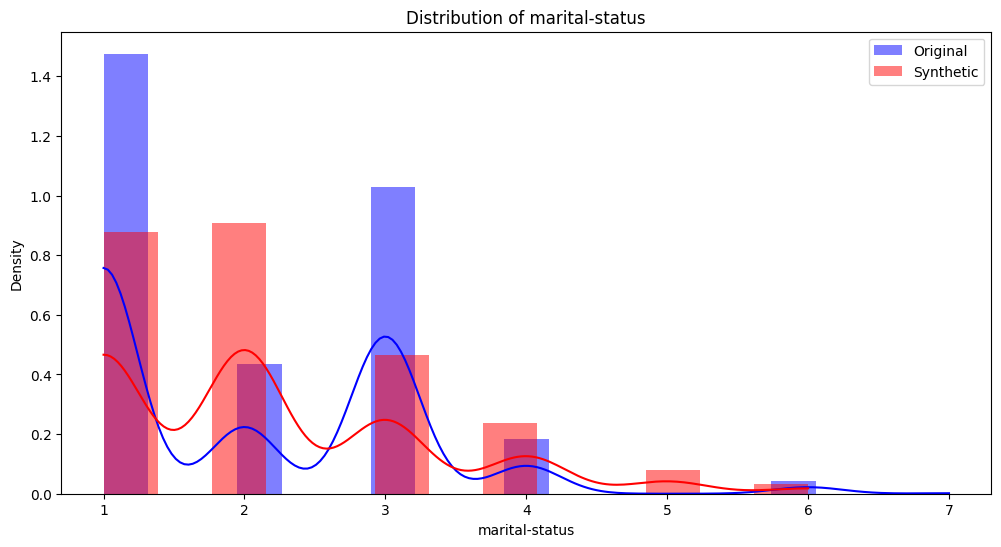

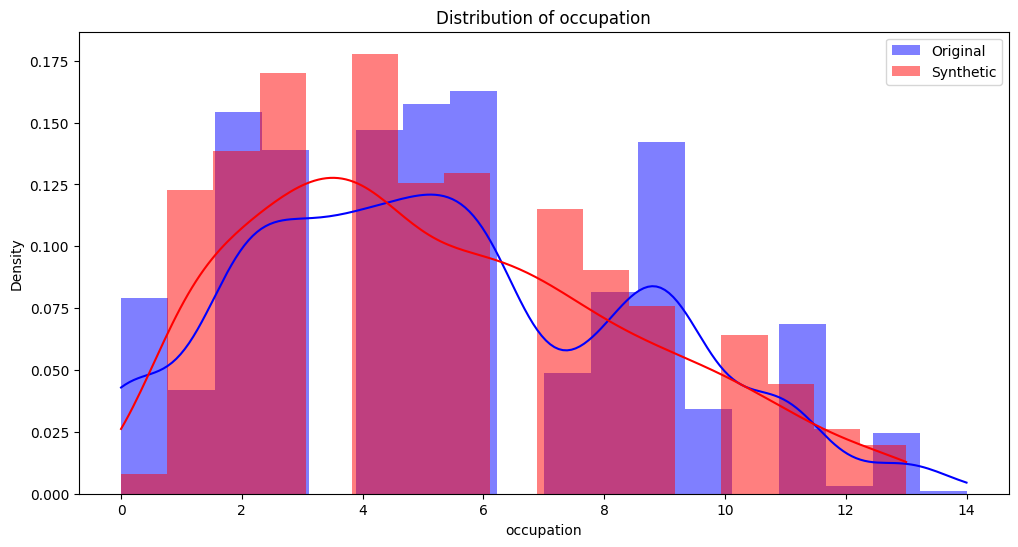

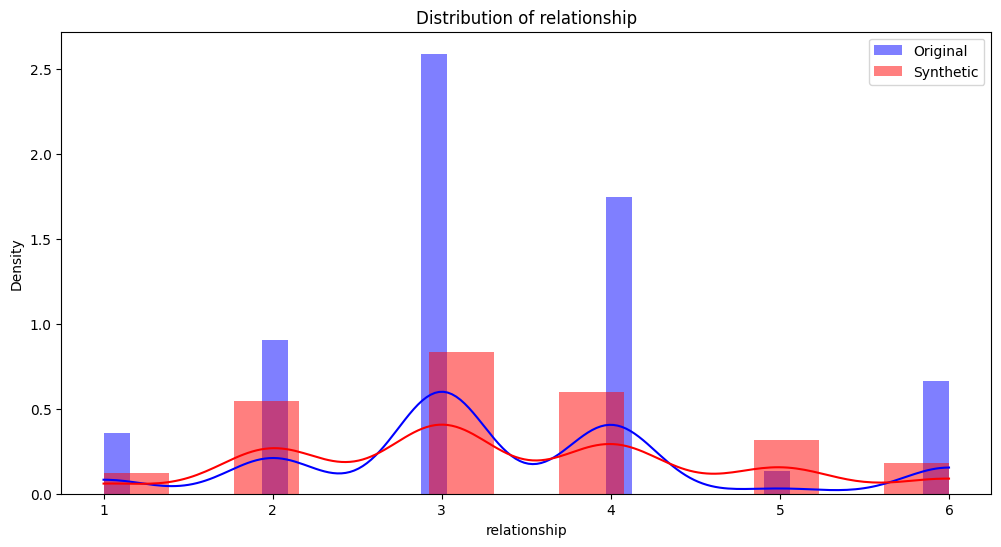

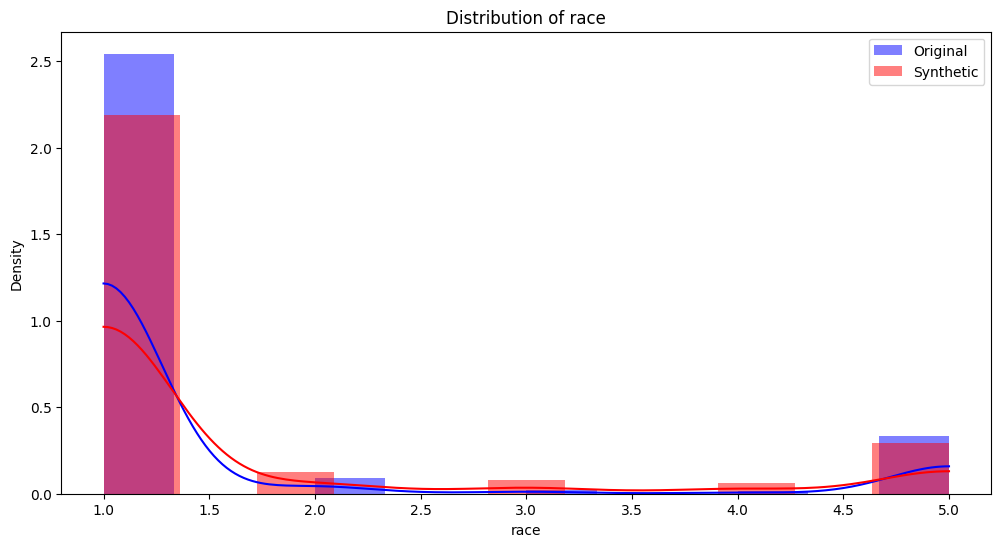

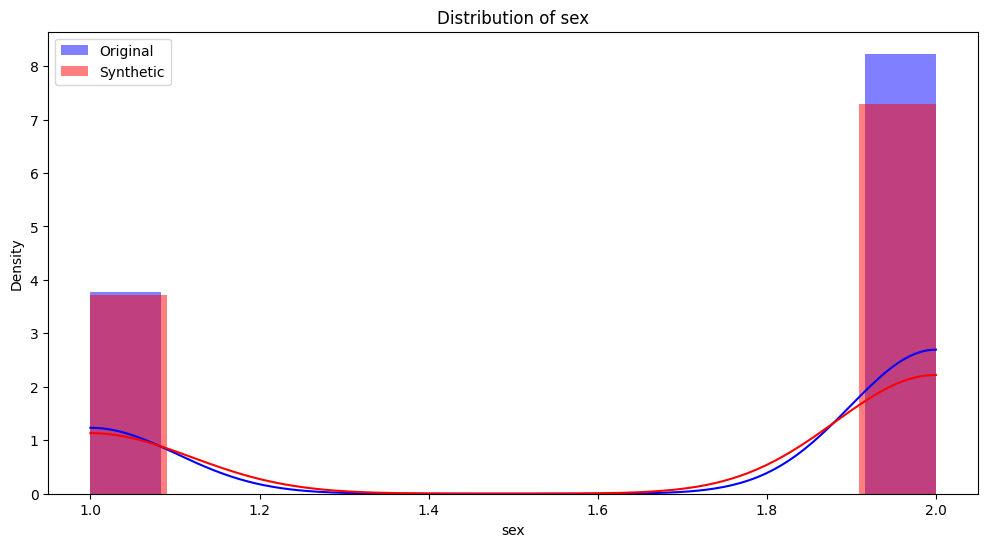

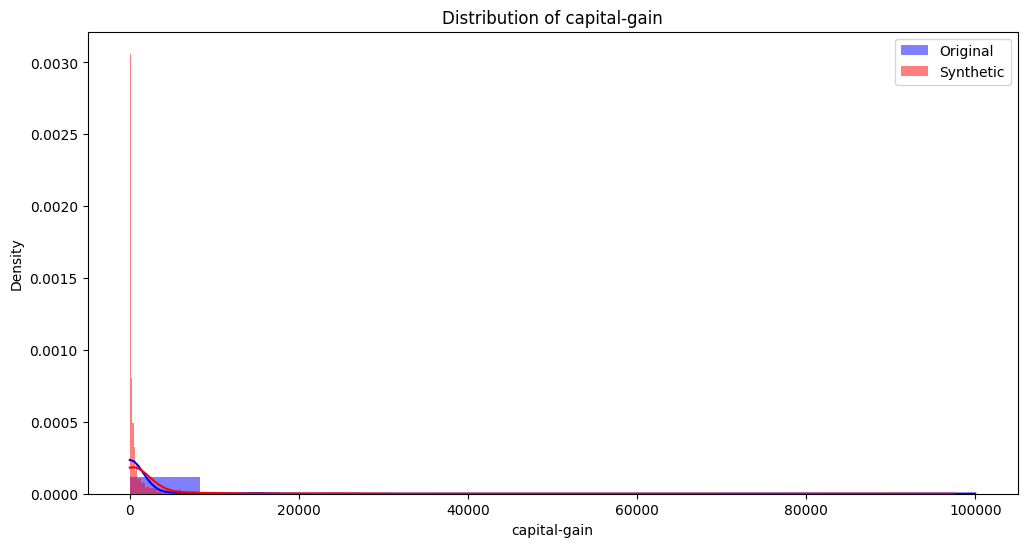

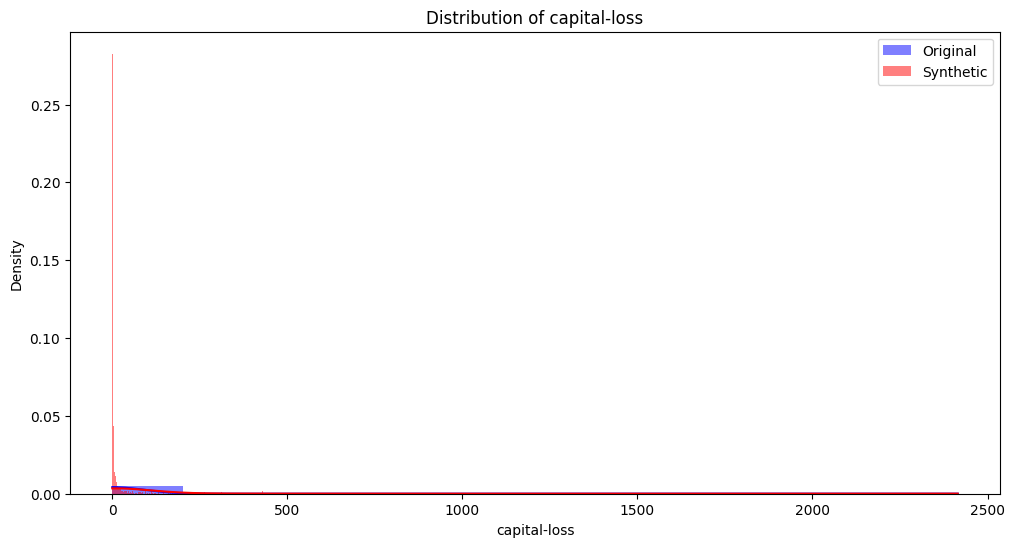

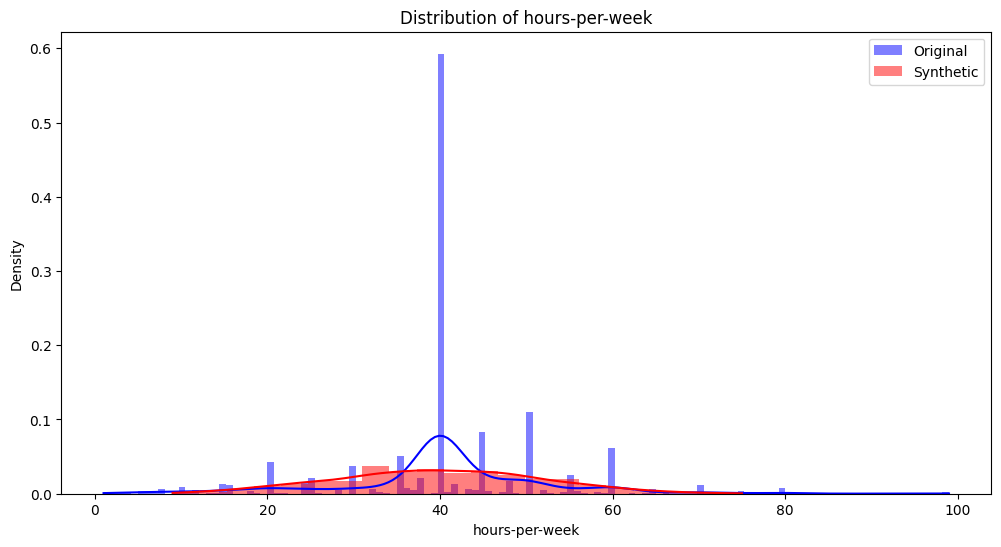

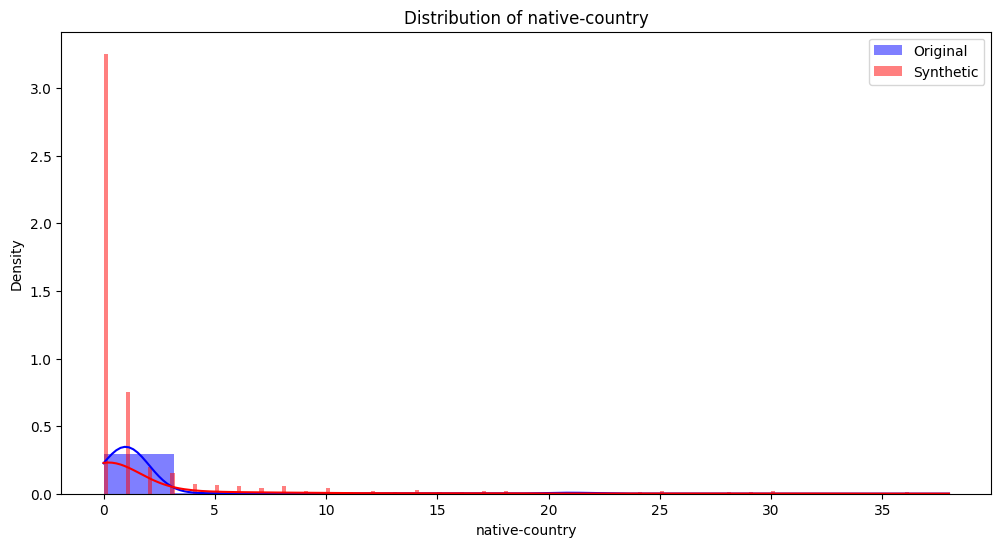

Original Data Statistics:
               age    workclass        fnlwgt    education  education-num  \
count  2000.000000  2000.000000  2.000000e+03  2000.000000    2000.000000   
mean     38.869000     1.636000  1.909227e+05     4.332500      10.111500   
std      13.391583     1.479053  1.066236e+05     3.393037       2.519572   
min      17.000000     0.000000  1.930200e+04     1.000000       1.000000   
25%      28.000000     1.000000  1.184985e+05     2.000000       9.000000   
50%      38.000000     1.000000  1.794620e+05     4.000000      10.000000   
75%      48.000000     1.000000  2.409275e+05     4.000000      13.000000   
max      90.000000     7.000000  1.033222e+06    16.000000      16.000000   

       marital-status   occupation  relationship         race          sex  \
count     2000.000000  2000.000000   2000.000000  2000.000000  2000.000000   
mean         2.032500     5.339000      3.374000     1.501000     1.686000   
std          1.122976     3.193772      1.2312

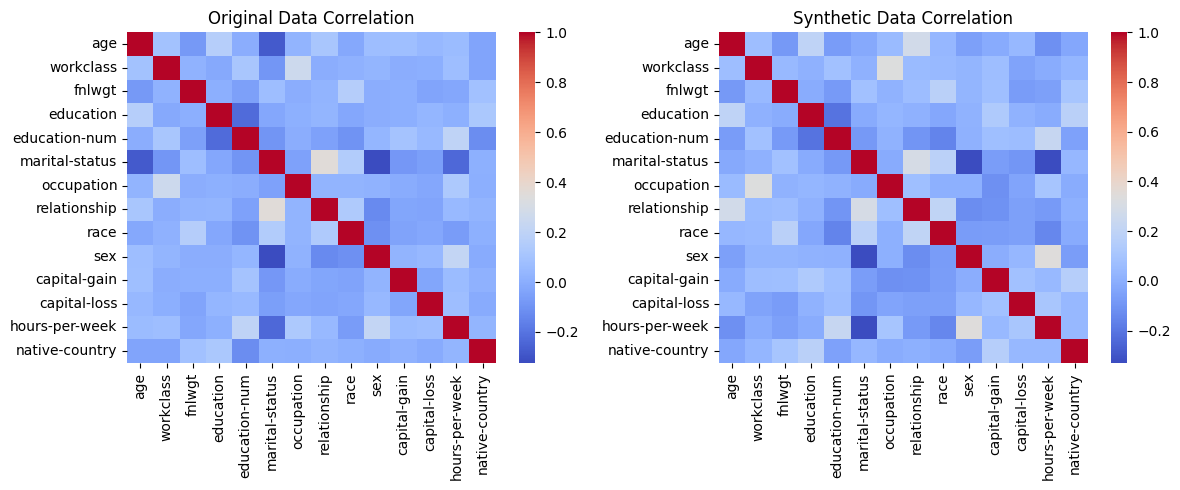

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(original, synthetic, feature_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(original[feature_name], color="blue", kde=True, stat="density", linewidth=0, label="Original")
    sns.histplot(synthetic[feature_name], color="red", kde=True, stat="density", linewidth=0, label="Synthetic")
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

# Compare distributions for all features
for feature in X.columns:
    compare_distributions(X, processed_synthetic_data, feature)

# Calculate and print basic statistics for each feature
print("Original Data Statistics:")
print(X.describe())
print("\nSynthetic Data Statistics:")
print(processed_synthetic_data.describe())

# Calculate and print correlation matrices
print("\nOriginal Data Correlation Matrix:")
print(X.corr())
print("\nSynthetic Data Correlation Matrix:")
print(processed_synthetic_data.corr())

# Optionally, visualize correlation matrices
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title("Original Data Correlation")
plt.subplot(122)
sns.heatmap(processed_synthetic_data.corr(), annot=False, cmap='coolwarm')
plt.title("Synthetic Data Correlation")
plt.tight_layout()
plt.show()